# Visualize


In [75]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important;ù } '
        '.end_space { min-heig§ht:0px !important; } '
    '</style>'
))
%load_ext autoreload
%autoreload 2

<ipython-input-75-69899bdc05d0>:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
def load_graphs(DATASET,MODEL,EXPL,MODE,verbose=True,lamb=0.001,normalize=True, raw=False):
    if EXPL in ["sal_edge","ig_edge","gnnexpl","pgexplainer","subgraphX","rgexpl"]:
        FOLDER = "edge_imp"
    else:
        FOLDER = "node_imp"

    path = "Explanations/NodeClassification/"+DATASET+"/"+MODEL+"/"+FOLDER+"/"+EXPL+"/"+MODE+"/"
    graphs = dict()

    labels = os.listdir(path)
    for lab in labels:
        graphs[int(lab)] = dict()
        for i in os.listdir(path+"/"+lab):
            if i[-7:] == "gpickle":
                gid,y = i.split(".")[0].split("_")
                if y == lab:
                    graphs[int(lab)][int(gid)] = g = nx.read_gpickle(path+"/"+lab+"/"+i)

    
    # get node/edge attrs
    g = graphs[0][list(graphs[0].keys())[0]]
    node_impo = nx.get_node_attributes(g,"node_imp")
    edge_impo = nx.get_edge_attributes(g,"edge_imp")

    # convert to node_impo
    if not edge_impo == {}:
        for lab , graph_dict in graphs.items():
            for gid,g in graph_dict.items():
                graphs[lab][gid] = from_edge_to_nodeExpl(g)    
    if raw:
        return graphs
    
    # clean_expl
    graphs = get_cleaned_graphs(graphs, explainer_name=EXPL, verbose=verbose, lamb=lamb)    

    # normalize 
    if normalize:
        all_node_imp = []
        for lab,graph_dict in graphs.items():
            if not graph_dict == None:
                for gid,g in graph_dict.items():
                    all_node_imp.extend(list(dict(nx.get_node_attributes(g,"node_imp")).values()))
        if not all_node_imp == []:
            min_val = np.min(all_node_imp)
            max_val = np.max(all_node_imp)

            for lab,graph_dict in graphs.items():
                if not graph_dict == None:
                    for gid,g in graph_dict.items():
                        for node in g.nodes():
                            orig = g.nodes()[node]["node_imp"]
                            g.nodes()[node]["node_imp_norm"] = (orig - min_val) / (max_val-min_val)

    return graphs


def from_edge_to_nodeExpl(g):
    for n in g.nodes():
        nei = list(nx.neighbors(g,n))
        scores2 = []
        for u in nei:
            scores2.append(g.edges()[(u,n)]["edge_imp"])
        g.nodes()[n]["node_imp"] = np.mean(scores2)
    return g


def clean(graphs, lab, lamb=0.001):
    graphs_to_keep = dict()
    for gid,g in graphs[lab].items():
        a = list(nx.get_node_attributes(g,"node_imp").values())
        un_a = np.unique(a)
        if len(un_a)>1:
            diff = un_a[-1] - un_a[0]
            if diff > lamb:
                graphs_to_keep[gid] = g
    return graphs_to_keep


def get_cleaned_graphs(graphs, explainer_name, verbose=True, lamb=0.001):
    originals , kepts = [] , []
    for c in sorted(graphs.keys()):
        original = len(graphs[c])
        kept = clean(graphs, c, lamb)
        originals.append(original)
        kepts.append(kept)
    
    if verbose:
        #print("{:.3f}".format(len(kept) / original),",","{:.3f}".format(len(res1)/orig_1))
        print(",".join(["{:.3f} ".format(len(kepts[i]) / originals[i]) for i in range(len(originals))]))  #f"{explainer_name:12}: \t", 
    
    return {i: kepts[i] if len(kepts[i])/originals[i] >= 0.5 else None for i in range(len(originals))}

# rq1

In [59]:
dataset = "BAShapes"
MODELS = ["GraphSAGE"]
GT_len = 9

da_plottare = dict()
tmp = []
for MODE in ["train"]:
    print("\t\t\t\t\t",MODE)
    for model_architecture in MODELS:
        print(model_architecture)

        EXPLs = ["cam","grad_cam","guided_bp","ig_node","grad_exp","pgmexplainer","gnnexpl","pgexplainer","subgraphX","rgexpl"]
        
        for expl in EXPLs:
            if expl == "-":
                print("- , -")
            else:
                print(expl)
                graphs = load_graphs(DATASET=dataset,
                                 MODEL=model_architecture,
                                 EXPL=expl,
                                 MODE=MODE,
                                 verbose=True,
                                 lamb=0.001,
                                 normalize=True)
                
                da_plottare[expl] = graphs
                

					 train
GraphSAGE
cam
0.000 ,0.000 ,0.000 ,0.000 
grad_cam
1.000 ,1.000 ,1.000 ,1.000 
guided_bp
0.000 ,0.000 ,0.000 ,0.000 
ig_node
1.000 ,1.000 ,1.000 ,1.000 
grad_exp
0.283 ,1.000 ,1.000 ,1.000 
pgmexplainer
0.950 ,0.195 ,0.172 ,0.141 
gnnexpl
1.000 ,1.000 ,1.000 ,1.000 
pgexplainer
0.000 ,0.000 ,0.000 ,0.000 
subgraphX
0.996 ,1.000 ,1.000 ,1.000 
rgexpl
0.996 ,1.000 ,1.000 ,1.000 


In [60]:
p = 520#637 #520 #354 #
y = 1 #1   #3
radius = 2
g1 = da_plottare["grad_cam"][y][p]
g1 = nx.ego_graph(g1,p,radius=radius)
pos = nx.spring_layout(g1,seed=10)

In [70]:
pos[523] = [-0.5,0.2]
pos[522] = [-0.5,0.6]
pos[520] = [-0.2,0.2]
pos[521] = [-0.2,0.6]
pos[524] = [0.1 ,0.4]

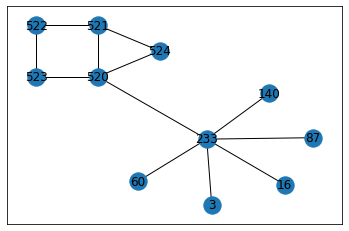

In [71]:
nx.draw_networkx(nx.ego_graph(da_plottare["grad_cam"][y][p],p,radius=radius),pos=pos,with_labels=True)

In [72]:
def my_plot(g,title=None,pos=None,ax=None):
    node_impo = nx.get_node_attributes(g,"node_imp_norm")
    if not ax == None:
        ax.set_title(title)
    nx.draw(g,pos,ax,node_color=list(node_impo.values()), cmap=plt.cm.Reds,node_size=50,edgecolors="gray")
    
def my_plot_edge(g,title=None,pos=None,ax=None):
    if not ax == None:
        ax.set_title(title)
    colors = list(nx.get_edge_attributes(g,"edge_imp").values())
    options = {
        "node_color":"#cccccc",
        "edge_color": colors,
        "width": 2,
        "edge_cmap": plt.cm.Reds,
        "with_labels": False,
        "node_size":25    }
    #nodes = nx.draw_networkx_nodes(g, pos)
    #nodes.set_edgecolor('red')
    nx.draw(g,pos,ax,**options)
    #plt.show()

In [73]:
nx.ego_graph(da_plottare["rgexpl"][y][p],p,radius=radius).nodes()

NodeView((3, 520, 233, 521, 523, 524, 522, 140, 16, 87, 60))

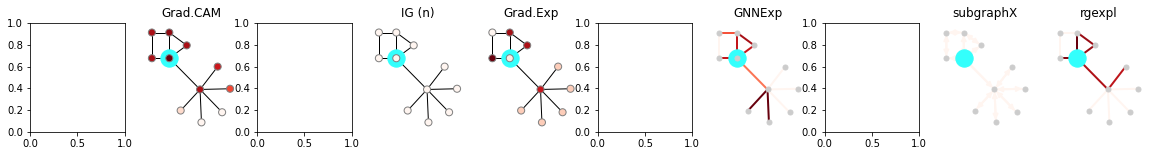

In [74]:
["cam","grad_cam","guided_bp","ig_node","grad_exp","pgmexplainer","sal_edge","ig_edge","gnnexpl","pgexpl","subgraphX","rgexpl"]
fig, ax = plt.subplots(1,10,figsize=(20,2))
#my_plot(da_plottare["cam"][p],title="CAM",pos=pos,ax=ax[0])


nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[1])
my_plot(nx.ego_graph(da_plottare["grad_cam"][y][p],p,radius=radius),title="Grad.CAM",pos=pos,ax=ax[1])
#my_plot(nx.ego_graph(da_plottare["guided_bp"][y][p],p,radius=3),title="Guid.BP",pos=pos,ax=ax[2])
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[3])
my_plot(nx.ego_graph(da_plottare["ig_node"][y][p],p,radius=radius),title="IG (n)",pos=pos,ax=ax[3])
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[4])
my_plot(nx.Graph(nx.ego_graph(da_plottare["grad_exp"][y][p],p,radius=radius)),title="Grad.Exp",pos=pos,ax=ax[4])
#my_plot(nx.ego_graph(da_plottare["pgmexplainer"][y][p],p,radius=3),title="PGMExp",pos=pos,ax=ax[5])
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[6])
my_plot_edge(nx.ego_graph(da_plottare["gnnexpl"][y][p],p,radius=radius),title="GNNExp",pos=pos,ax=ax[6])
#my_plot_edge(nx.ego_graph(da_plottare["pgexpl"][y][p],p,radius=3),title="PGExp",pos=pos,ax=ax[7])
my_plot_edge(nx.ego_graph(da_plottare["subgraphX"][y][p],p,radius=radius),title="subgraphX",pos=pos,ax=ax[8])
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[8])
my_plot_edge(nx.ego_graph(da_plottare["rgexpl"][y][p],p,radius=radius),title="rgexpl",pos=pos,ax=ax[9])
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[9])

plt.savefig("Explanations/images/RQ11/node/BAshapes_graphSAGE_1.pdf")

# gabri

In [48]:
from metrics.utils_nc import set_seeds
from metrics.utils_nc import load_graphs as load_graphs_gabri
from Datasets.synthetics import Infection
set_seeds()
dataset = Infection()
y = dataset.data.y.numpy()
infected_nodes = np.argwhere(y == 0)[:, 0]

/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
dataset = "Infection"
MODELS = ["GraphSAGE"]

EXPLs = ["cam","grad_cam","guided_bp","ig_node","grad_exp","pgmexplainer","gnnexpl","pgexplainer","subgraphX"]

da_plottare = dict()
tmp = []
for MODE in ["train"]:
    print("\t\t\t\t\t",MODE)
    for model_architecture in MODELS:
        print(model_architecture)
            
        for expl in EXPLs:
            if expl == "-":
                print("- , -")
            else:
                graphs = load_graphs_gabri(DATASET=dataset,
                                 MODEL=model_architecture,
                                 EXPL=expl,
                                 MODE=MODE,
                                 verbose=True,
                                 lamb=0.001,
                                 normalize=True)
                
                da_plottare[expl] = graphs

					 train
GraphSAGE
 1.000  1.000  1.000	cam
 0.975  1.000  1.000	grad_cam
 0.900  0.902  0.891	guided_bp
 1.000  1.000  1.000	ig_node
 0.975  0.641  0.969	grad_exp
 0.325  0.490  0.383	pgmexplainer


/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/anaconda3/envs/geo_new/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 0.975  1.000  0.969	gnnexpl
 0.000  0.000  0.000	pgexplainer
 1.000  1.000  1.000	subgraphX


FileNotFoundError: [Errno 2] No such file or directory: 'Explanations/NodeClassification/Infection/GraphSAGE/node_imp/rgexpl/train/'

In [50]:

def get_inf_node_to_plot(g1,infected_nodes):
    tmp = []
    for i in infected_nodes:
        if i in list(g1.nodes()):
            tmp.append(i)
    return tmp

In [51]:
p = 891  #637 #520 #354 #
y = 1 #1   #3
radius = 2


g1 = da_plottare["cam"][y][p]
g1 = nx.ego_graph(g1,p,radius=radius,undirected=True)
g11 = nx.ego_graph(g1,p,radius=radius,undirected=False)

g111 = g1.copy()

for e1 in g1.edges():
    
    if e1 in list(g11.edges()):
        
        g111.remove_edge(e1[0],e1[1])

g111.remove_nodes_from(list(nx.isolates(g111)))
g1 = g111.copy()

for n in g111:
    if not nx.has_path(g111,n,p):
        g1.remove_node(n)
        
        

infet = get_inf_node_to_plot(g1,infected_nodes)

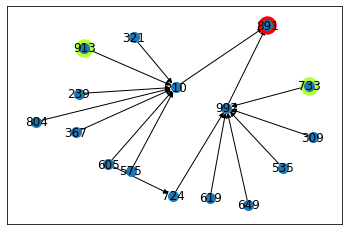

In [53]:
pos = nx.spring_layout(g1,seed=11)
nx.draw_networkx_nodes(infet,pos,node_size=300,node_color="#B2FF33")
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="red")
nx.draw_networkx(g1,pos,node_size=100)

In [54]:

    
def plot_gabri_compress(da_plottare,name,y,p,radius,infected_nodes,pos,title,ax):

    g1 = da_plottare[name][y][p]
    g1 = nx.ego_graph(g1,p,radius=radius,undirected=True)
    g11 = nx.ego_graph(g1,p,radius=radius,undirected=False)

    g111 = g1.copy()

    for e1 in g1.edges():

        if e1 in list(g11.edges()):

            g111.remove_edge(e1[0],e1[1])

    g111.remove_nodes_from(list(nx.isolates(g111)))
    g1 = g111.copy()

    for n in g111:
        if not nx.has_path(g111,n,p):
            g1.remove_node(n)



    infet = get_inf_node_to_plot(g1,infected_nodes)

    pos = nx.spring_layout(g1,seed=11)
    nx.draw_networkx_nodes(infet,pos,node_size=300,node_color="#B2FF33",ax=ax)
    nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax)

    my_plot(g1,pos=pos,title=title,ax=ax)
    
def plot_gabri_compress_edge(da_plottare,name,y,p,radius,infected_nodes,pos,title,ax):

    g1 = da_plottare[name][y][p]
    g1 = nx.ego_graph(g1,p,radius=radius,undirected=True)
    g11 = nx.ego_graph(g1,p,radius=radius,undirected=False)

    g111 = g1.copy()

    for e1 in g1.edges():

        if e1 in list(g11.edges()):

            g111.remove_edge(e1[0],e1[1])

    g111.remove_nodes_from(list(nx.isolates(g111)))
    g1 = g111.copy()

    for n in g111:
        if not nx.has_path(g111,n,p):
            g1.remove_node(n)



    infet = get_inf_node_to_plot(g1,infected_nodes)

    pos = nx.spring_layout(g1,seed=11)
    nx.draw_networkx_nodes(infet,pos,node_size=300,node_color="#B2FF33",ax=ax)
    nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax)

    my_plot_edge(g1,title=title,pos=pos,ax=ax)
    

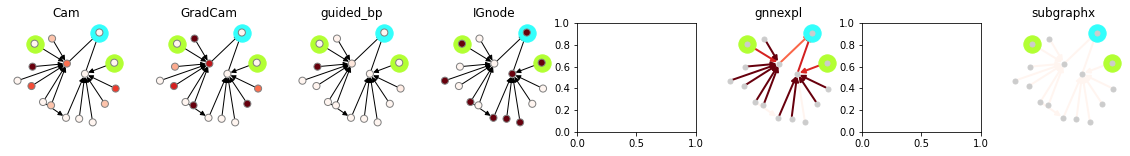

In [56]:

fig, ax = plt.subplots(1,8,figsize=(20,2))

plot_gabri_compress(da_plottare,"cam",y,p,radius,infected_nodes,pos,"Cam",ax[0])
plot_gabri_compress(da_plottare,"grad_cam",y,p,radius,infected_nodes,pos,"GradCam",ax[1])
plot_gabri_compress(da_plottare,"guided_bp",y,p,radius,infected_nodes,pos,"guided_bp",ax[2])
plot_gabri_compress(da_plottare,"ig_node",y,p,radius,infected_nodes,pos,"IGnode",ax[3])
#plot_gabri_compress(da_plottare,"pgmexplainer",y,p,radius,infected_nodes,pos,"pgme",ax[4])
plot_gabri_compress_edge(da_plottare,"gnnexpl",y,p,radius,infected_nodes,pos,"gnnexpl",ax[5])
#plot_gabri_compress_edge(da_plottare,"pgexplainer",y,p,radius,infected_nodes,pos,"pgexpl",ax[6])
plot_gabri_compress_edge(da_plottare,"subgraphX",y,p,radius,infected_nodes,pos,"subgraphx",ax[7])

plt.savefig("Explanations/images/RQ11/node/infectopn_graphSAGE_1_v1.pdf")

# rq2 
## bashapes

In [77]:
dataset = "BAShapes"
MODELS = ["GCN","GIN","GraphSAGE"]
GT_len = 9

da_plottare = dict()
tmp = []
for MODE in ["train"]:
    print("\t\t\t\t\t",MODE)
    for model_architecture in MODELS:
        print(model_architecture)

        EXPLs = ["gnnexpl"]
        
        for expl in EXPLs:
            if expl == "-":
                print("- , -")
            else:
                print(expl)
                graphs = load_graphs(DATASET=dataset,
                                 MODEL=model_architecture,
                                 EXPL=expl,
                                 MODE=MODE,
                                 verbose=True,
                                 lamb=0.001,
                                 normalize=True)
                
                da_plottare[model_architecture] = graphs[1]
                

					 train
GCN
gnnexpl
1.000 ,1.000 ,1.000 ,1.000 
GIN
gnnexpl
1.000 ,1.000 ,1.000 ,1.000 
GraphSAGE
gnnexpl
1.000 ,1.000 ,1.000 ,1.000 


In [ ]:
p = 526#637 #520 #354 #
y = 1 #1   #3
radius = 2
g1 = da_plottare["GCN"][p]
g1 = nx.ego_graph(g1,p,radius=radius)
pos = nx.spring_layout(g1,seed=10)

In [ ]:
nx.draw(g1,pos)

In [ ]:

fig, ax = plt.subplots(1,8,figsize=(20,2))
#my_plot(da_plottare["cam"][p],title="CAM",pos=pos,ax=ax[0])


nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[1])
my_plot(nx.ego_graph(da_plottare["GCN"][p],p,radius=radius),title="GCN",pos=pos,ax=ax[1])
#my_plot(nx.ego_graph(da_plottare["guided_bp"][y][p],p,radius=3),title="Guid.BP",pos=pos,ax=ax[2])
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[3])
my_plot(nx.ego_graph(da_plottare["GIN"][p],p,radius=radius),title="GIN",pos=pos,ax=ax[3])
nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[4])
my_plot(nx.Graph(nx.ego_graph(da_plottare["GraphSAGE"][p],p,radius=radius)),title="SAGE",pos=pos,ax=ax[4])
#my_plot(nx.ego_graph(da_plottare["pgmexplainer"][y][p],p,radius=3),title="PGMExp",pos=pos,ax=ax[5])
#my_plot_edge(nx.ego_graph(da_plottare["pgexpl"][y][p],p,radius=3),title="PGExp",pos=pos,ax=ax[7])

plt.savefig("paper/TABELLINE_X_PAPER/nodi/BAshapes_graphSAGE_rq2.pdf")

## Gabri

In [37]:
from utils import set_seeds
from utils import load_graphs as load_graphs_gabri
from Datasets.synthetics import Infection
set_seeds()
dataset = Infection()
y = dataset.data.y.numpy()
infected_nodes = np.argwhere(y == 0)[:, 0]

In [38]:
dataset = "Infection"
MODELS = ["GCN","GAT","GraphSAGE"]

EXPLs = ["gnnexpl"]

da_plottare = dict()
tmp = []
for MODE in ["train"]:
    print("\t\t\t\t\t",MODE)
    for model_architecture in MODELS:
        print(model_architecture)
            
        for expl in EXPLs:
            if expl == "-":
                print("- , -")
            else:
                graphs = load_graphs_gabri(DATASET=dataset,
                                 MODEL=model_architecture,
                                 EXPL=expl,
                                 MODE=MODE,
                                 verbose=True,
                                 lamb=0.001,
                                 normalize=True)
                
                da_plottare[model_architecture] = graphs[1]

					 train
GCN


/home/antonio/anaconda3/envs/geometric_new/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonio/anaconda3/envs/geometric_new/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 0.000  1.000  0.969	gnnexpl
GAT
 1.000  1.000  0.969	gnnexpl
GraphSAGE
 0.975  1.000  0.969	gnnexpl


In [39]:
da_plottare["GAT"]

{817: <networkx.classes.digraph.DiGraph at 0x7eff67a481c0>,
 143: <networkx.classes.digraph.DiGraph at 0x7eff67a48040>,
 835: <networkx.classes.digraph.DiGraph at 0x7eff67a48310>,
 72: <networkx.classes.digraph.DiGraph at 0x7eff67a48100>,
 914: <networkx.classes.digraph.DiGraph at 0x7eff67a480d0>,
 944: <networkx.classes.digraph.DiGraph at 0x7eff67a48070>,
 47: <networkx.classes.digraph.DiGraph at 0x7eff67a48160>,
 723: <networkx.classes.digraph.DiGraph at 0x7eff67a483a0>,
 930: <networkx.classes.digraph.DiGraph at 0x7eff67a48220>,
 412: <networkx.classes.digraph.DiGraph at 0x7eff67a48280>,
 625: <networkx.classes.digraph.DiGraph at 0x7eff67a48880>,
 865: <networkx.classes.digraph.DiGraph at 0x7eff67a48b20>,
 102: <networkx.classes.digraph.DiGraph at 0x7eff67a488e0>,
 608: <networkx.classes.digraph.DiGraph at 0x7eff67a48910>,
 206: <networkx.classes.digraph.DiGraph at 0x7eff67a487c0>,
 105: <networkx.classes.digraph.DiGraph at 0x7eff67a48a60>,
 837: <networkx.classes.digraph.DiGraph at

In [62]:

    
def plot_gabri_compress_edge_rq2(da_plottare,name,y,p,radius,infected_nodes,pos,title,ax,seed=11):

    g1 = da_plottare[name][p]
    g1 = nx.ego_graph(g1,p,radius=radius,undirected=True)
    g11 = nx.ego_graph(g1,p,radius=radius,undirected=False)

    g111 = g1.copy()

    for e1 in g1.edges():

        if e1 in list(g11.edges()):

            g111.remove_edge(e1[0],e1[1])

    g111.remove_nodes_from(list(nx.isolates(g111)))
    g1 = g111.copy()

    for n in g111:
        if not nx.has_path(g111,n,p):
            g1.remove_node(n)



    infet = get_inf_node_to_plot(g1,infected_nodes)

    pos = nx.spring_layout(g1,seed=seed)
    nx.draw_networkx_nodes(infet,pos,node_size=300,node_color="#B2FF33",ax=ax)
    nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax)

    my_plot_edge(g1,title=title,pos=pos,ax=ax)
    

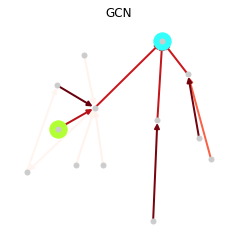

In [68]:
p = 184  #637 #520 #354 #
y = 1 #1   #3
radius = 2
g1 = da_plottare["GAT"][p]
g1 = nx.ego_graph(g1,p,radius=radius)
pos = nx.spring_layout(g1,seed=355)
seed = 1310
fig, ax = plt.subplots(1,1,figsize=(4,4))
plot_gabri_compress_edge_rq2(da_plottare,"GCN",y,p,radius,infected_nodes,pos,"GCN",ax,seed=seed)

In [69]:
g1.nodes(data=True)

NodeDataView({419: {'node_imp': 0.0, 'node_imp_norm': nan}, 163: {'node_imp': 0.0, 'node_imp_norm': nan}, 454: {'node_imp': 0.0, 'node_imp_norm': nan}, 472: {'node_imp': 0.0, 'node_imp_norm': nan}, 296: {'node_imp': 0.0, 'node_imp_norm': nan}, 520: {'node_imp': 0.0, 'node_imp_norm': nan}, 616: {'node_imp': 0.0, 'node_imp_norm': nan}, 106: {'node_imp': 0.0, 'node_imp_norm': nan}, 77: {'node_imp': 0.0, 'node_imp_norm': nan}, 750: {'node_imp': 0.0, 'node_imp_norm': nan}, 398: {'node_imp': 0.0, 'node_imp_norm': nan}, 48: {'node_imp': 0.0, 'node_imp_norm': nan}, 117: {'node_imp': 0.0, 'node_imp_norm': nan}, 87: {'node_imp': 0.0, 'node_imp_norm': nan}, 184: {'node_imp': 0.0, 'node_imp_norm': nan}, 508: {'node_imp': 0.0, 'node_imp_norm': nan}, 893: {'node_imp': nan, 'node_imp_norm': nan}})

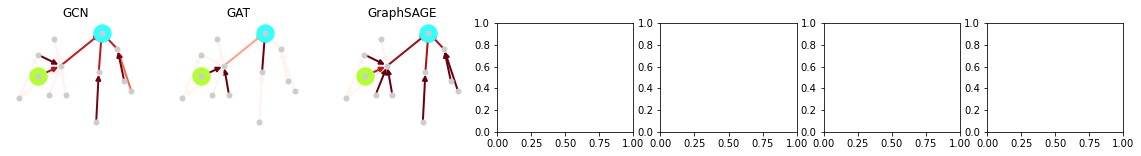

In [71]:

fig, ax = plt.subplots(1,7,figsize=(20,2))
plot_gabri_compress_edge_rq2(da_plottare,"GCN",y,p,radius,infected_nodes,pos,"GCN",ax[0],seed=seed)
plot_gabri_compress_edge_rq2(da_plottare,"GAT",y,p,radius,infected_nodes,pos,"GAT",ax[1],seed=seed)
plot_gabri_compress_edge_rq2(da_plottare,"GraphSAGE",y,p,radius,infected_nodes,pos,"GraphSAGE",ax[2],seed=seed)
#plot_gabri_compress_edge(da_plottare,"pgexplainer",y,p,radius,infected_nodes,pos,"pgexpl",ax[6])

plt.savefig("paper/TABELLINE_X_PAPER/nodi/infectopn_graphSAGE_rq2_v2.pdf")

# singole classi 
# shapes

In [166]:
dataset = "BAShapes"
MODELS = [("GCN","guided_bp"),("GIN","guided_bp"),("Cheb","grad_cam"),("GraphSAGE","grad_cam")] # 1
MODELS = [("GCN","pgexplainer"),("GIN","grad_cam"),("Cheb","grad_cam"),("GraphSAGE","grad_cam")] # 2
MODELS = [("GCN","pgexplainer"),("GIN","gnnexpl"),("Cheb","grad_cam"),("GraphSAGE","gnnexpl")] # 3



MODELS = [("GCN","guided_bp"),("GIN","guided_bp"),("Cheb","rgexpl"),("GraphSAGE","gnnexpl")] # 1
MODELS = [("GCN","pgexplainer"),("GIN","grad_cam"),("Cheb","grad_cam"),("GraphSAGE","grad_cam")] # 2
#MODELS = [("GCN","pgexplainer"),("GIN","rgexpl"),("Cheb","grad_cam"),("GraphSAGE","gnnexpl")] # 3 # p = 614
GT_len = 9

da_plottare = dict()
tmp = []
for MODE in ["train"]:
    print("\t\t\t\t\t",MODE)
    for model_architecture,expl in MODELS:
        print(model_architecture, expl)
        graphs = load_graphs(DATASET=dataset,
                         MODEL=model_architecture,
                         EXPL=expl,
                         MODE=MODE,
                         verbose=True,
                         lamb=0.001,
                         normalize=True)

        da_plottare[model_architecture] = (expl,graphs[2])


					 train
GCN pgexplainer
1.000 ,1.000 ,1.000 ,1.000 
GIN grad_cam
0.921 ,1.000 ,1.000 ,1.000 
Cheb grad_cam
1.000 ,1.000 ,1.000 ,1.000 
GraphSAGE grad_cam
1.000 ,1.000 ,1.000 ,1.000 


In [113]:
# class = 3

p = 614 # 382#620
a = nx.Graph(da_plottare["GCN"][1][p])
b = nx.Graph(da_plottare["GIN"][1][p])
c = nx.Graph(da_plottare["Cheb"][1][p])
d = nx.Graph(da_plottare["GraphSAGE"][1][p])

g1 = nx.ego_graph(a,p,radius=radius)
pos = nx.spring_layout(g1,seed=10)

pos[610] = [0.3,0]
pos[613] = [0.3,-0.5]
pos[612] = [0.0,-0.5]
pos[611] = [0.0,-0]
pos[614] = [0.15,0.35]
pos[115] = [0.55,-0.25]

KeyError: 614

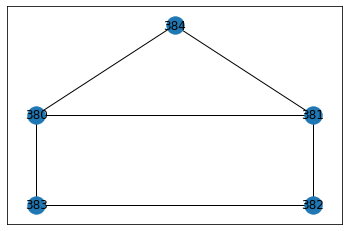

In [167]:
# class = 2

p = 382 #620
a = nx.Graph(da_plottare["GCN"][1][p])
b = nx.Graph(da_plottare["GIN"][1][p])
c = nx.Graph(da_plottare["Cheb"][1][p])
d = nx.Graph(da_plottare["GraphSAGE"][1][p])

g1 = nx.ego_graph(a,p,radius=radius)
pos = nx.spring_layout(g1,seed=10)
pos[381] = [0.3,0]
pos[382] = [0.3,-2]
pos[383] = [0.0,-2]
pos[380] = [0.0,-0]
pos[384] = [0.15,2]
nx.draw_networkx(g1,pos)

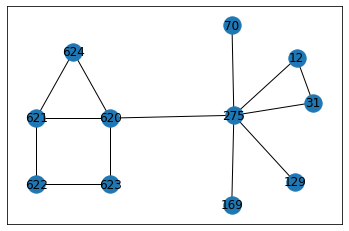

In [162]:
# class = 1

p = 620
a = nx.Graph(da_plottare["GCN"][1][p])
b = nx.Graph(da_plottare["GIN"][1][p])
c = nx.Graph(da_plottare["Cheb"][1][p])
d = nx.Graph(da_plottare["GraphSAGE"][1][p])

g1 = nx.ego_graph(a,p,radius=radius)
pos = nx.spring_layout(g1,seed=10)

pos[620] = [-0.3,0]
pos[624] = [-0.5,0.3]
pos[621] = [-0.7  ,0]
pos[622] = [-0.7  ,-0.3]
pos[623] = [-0.3  ,-0.3]
nx.draw_networkx(g1,pos)

In [163]:
pos[624]

[-0.5, 0.3]

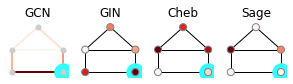

In [169]:
fig, ax = plt.subplots(1,4,figsize=(10,1))
#my_plot(da_plottare["cam"][p],title="CAM",pos=pos,ax=ax[0])

nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[0])
my_plot_edge(nx.ego_graph(a,p,radius=radius),title="GCN",pos=pos,ax=ax[0])

nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[1])
my_plot(nx.ego_graph(b,p,radius=radius),title="GIN",pos=pos,ax=ax[1])

nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[2])
my_plot(nx.ego_graph(c,p,radius=radius),title="Cheb",pos=pos,ax=ax[2])

nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax[3])
my_plot(nx.ego_graph(d,p,radius=radius),title="Sage",pos=pos,ax=ax[3])

plt.savefig("Explanations/images/RQ13/node/shapes_rq3_2.pdf")

# Infections

In [12]:
def get_inf_node_to_plot(g1,infected_nodes):
    tmp = []
    for i in infected_nodes:
        if i in list(g1.nodes()):
            tmp.append(i)
    return tmp

In [13]:
from utils import set_seeds
from utils import load_graphs as load_graphs_gabri
from Datasets.synthetics import Infection
set_seeds()
dataset = Infection()
y = dataset.data.y.numpy()
infected_nodes = np.argwhere(y == 0)[:, 0]

    
def plot_gabri_compress_rq3(da_plottare,name,y,p,radius,infected_nodes,pos,title,ax):
    g1 = da_plottare[name][1][p]
    g1 = nx.ego_graph(g1,p,radius=radius)
    infet = get_inf_node_to_plot(g1,infected_nodes)
    nx.draw_networkx_nodes(infet,pos,node_size=300,node_color="#B2FF33",ax=ax)
    nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax)
    my_plot(g1,title=title,pos=pos,ax=ax)

In [14]:

    
def plot_gabri_compress_rq3(da_plottare,name,y,p,radius,infected_nodes,pos,title,ax,seed=11):
    
    
    g1 = da_plottare[name][1][p]
    g1 = nx.ego_graph(g1,p,radius=radius,undirected=True)
    g11 = nx.ego_graph(g1,p,radius=radius,undirected=False)

    g111 = g1.copy()

    for e1 in g1.edges():

        if e1 in list(g11.edges()):

            g111.remove_edge(e1[0],e1[1])

    g111.remove_nodes_from(list(nx.isolates(g111)))
    g1 = g111.copy()

    for n in g111:
        if not nx.has_path(g111,n,p):
            g1.remove_node(n)



    infet = get_inf_node_to_plot(g1,infected_nodes)

    pos = nx.spring_layout(g1,seed=seed)
    nx.draw_networkx_nodes(infet,pos,node_size=300,node_color="#B2FF33",ax=ax)
    nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax)

    my_plot(g1,title=title,pos=pos,ax=ax)
    
def plot_gabri_compress_edge_rq3(da_plottare,name,y,p,radius,infected_nodes,pos,title,ax,seed=11):

    g1 = da_plottare[name][1][p]
    g1 = nx.ego_graph(g1,p,radius=radius,undirected=True)
    g11 = nx.ego_graph(g1,p,radius=radius,undirected=False)

    g111 = g1.copy()

    for e1 in g1.edges():

        if e1 in list(g11.edges()):

            g111.remove_edge(e1[0],e1[1])

    g111.remove_nodes_from(list(nx.isolates(g111)))
    g1 = g111.copy()

    for n in g111:
        if not nx.has_path(g111,n,p):
            g1.remove_node(n)



    infet = get_inf_node_to_plot(g1,infected_nodes)

    pos = nx.spring_layout(g1,seed=seed)
    nx.draw_networkx_nodes(infet,pos,node_size=300,node_color="#B2FF33",ax=ax)
    nx.draw_networkx_nodes([p],pos,node_size=300,node_color="#33FFFC",ax=ax)

    my_plot_edge(g1,title=title,pos=pos,ax=ax)
    

In [5]:
dataset = "Infection"
MODELS = ["GCN","GAT","GraphSAGE"]

MODELS = [("GCN","grad_cam"),("GAT","guided_bp"),("GIN","guided_bp"),("Cheb","cam"),("GraphSAGE","cam")] # 1
#MODELS = [("GCN","grad_cam"),("GAT","cam"),("GIN","grad_cam"),("Cheb","cam"),("GraphSAGE","grad_cam")] # 2
#MODELS = [("GCN","pgexplainer"),("GAT","guided_bp"),("GIN","gnnexpl"),("Cheb","grad_cam"),("GraphSAGE","gnnexpl")] # 3

da_plottare = dict()
tmp = []
for MODE in ["train"]:
    print("\t\t\t\t\t",MODE)
    for model_architecture,expl in MODELS:
        print(model_architecture, expl)
        graphs = load_graphs_gabri(DATASET=dataset,
                         MODEL=model_architecture,
                         EXPL=expl,
                         MODE=MODE,
                         verbose=True,
                         lamb=0.001,
                         normalize=True)

        da_plottare[model_architecture] = (expl,graphs[1])


					 train
GCN grad_cam
 1.000  1.000  0.997	grad_cam
GAT guided_bp
 0.409  0.507  0.000	guided_bp
GIN guided_bp
 0.500  0.990  0.937	guided_bp
Cheb cam
 1.000  1.000  1.000	cam
GraphSAGE cam
 1.000  1.000  1.000	cam


In [6]:
minimo = 10000
for i,j in da_plottare["GAT"][1].items():
    g1 = nx.ego_graph(j,i,radius=3)
    
    
    if len(g1.edges())<minimo:
        print(i,len(g1.edges()),len(g1.nodes()))
        minimo = len(g1.edges())

835 106 79
914 20 20
983 0 1


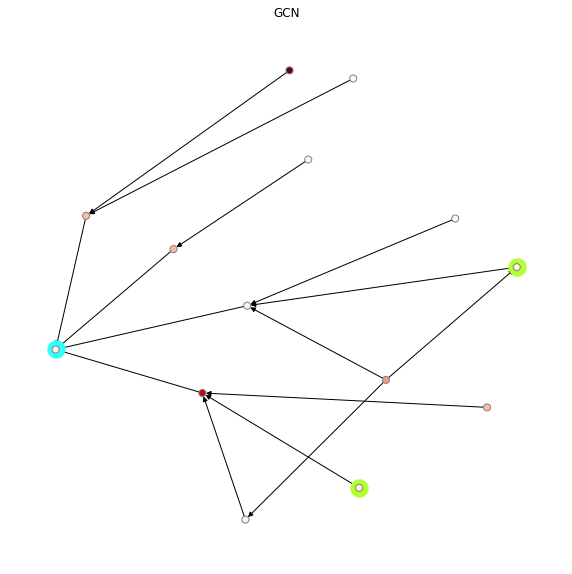

In [17]:
p = 914 # 483 #797 #
radius = 2
fig, ax = plt.subplots(1,1,figsize=(10,10))
pos = nx.spring_layout(da_plottare["GAT"][1][p])
plot_gabri_compress_rq3(da_plottare,"GCN",y,p,radius,infected_nodes,pos,"GCN",ax,seed=14)

In [95]:
len(g1.edges())

48

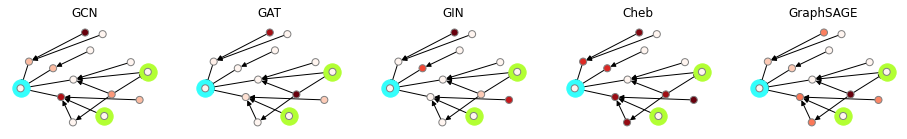

In [18]:
seed = 14
fig, ax = plt.subplots(1,5,figsize=(16,2))
plot_gabri_compress_rq3(da_plottare,"GCN",y,p,radius,infected_nodes,pos,"GCN",ax[0],seed=seed)
plot_gabri_compress_rq3(da_plottare,"GAT",y,p,radius,infected_nodes,pos,"GAT",ax[1],seed=seed)
plot_gabri_compress_rq3(da_plottare,"GIN",y,p,radius,infected_nodes,pos,"GIN",ax[2],seed=seed)
plot_gabri_compress_rq3(da_plottare,"Cheb",y,p,radius,infected_nodes,pos,"Cheb",ax[3],seed=seed)
plot_gabri_compress_rq3(da_plottare,"GraphSAGE",y,p,radius,infected_nodes,pos,"GraphSAGE",ax[4],seed=seed)

plt.savefig("paper/TABELLINE_X_PAPER/nodi/infection_rq3_1_v2.pdf")

# eliminami

In [10]:
g1 = nx.read_gpickle("Explanations/GraphClassification/BA_2grid/GCN/node_imp/cam/train/0/1001_0.gpickle")
g2 = nx.read_gpickle("Explanations/GraphClassification/BA_2grid/GCN/node_imp/cam/train/1/1003_1.gpickle")

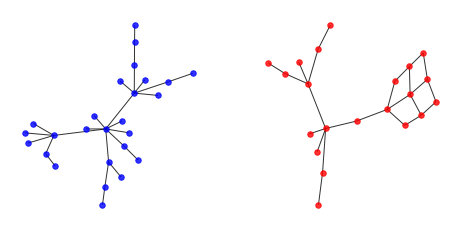

In [14]:

fig, ax = plt.subplots(1,2,figsize=(8,4))
nx.draw(g1,ax=ax[0],node_color="Blue",alpha=0.8,node_size=30)
nx.draw(g2,ax=ax[1],node_color="Red",alpha=0.8,node_size=30)
plt.savefig("eliminami_talk/tmp_grid.png")

In [58]:
g1 = nx.read_gpickle("Explanations/GraphClassification/BA_2grid_house/GCN/node_imp/cam/train/0/1001_0.gpickle")
g2 = nx.read_gpickle("Explanations/GraphClassification/BA_2grid_house/GCN/node_imp/cam/train/0/1004_0.gpickle")
g3 = nx.read_gpickle("Explanations/GraphClassification/BA_2grid_house/GCN/node_imp/cam/train/1/507_1.gpickle")

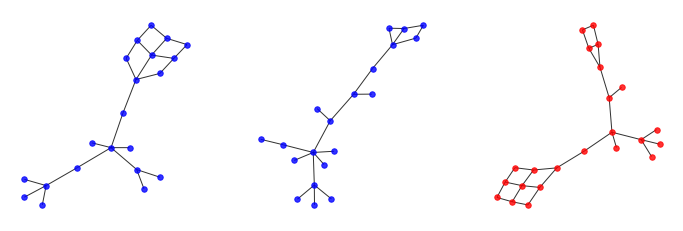

In [59]:

fig, ax = plt.subplots(1,3,figsize=(12,4))
nx.draw(g1,ax=ax[0],pos=nx.spring_layout(g1,seed=11),node_color="Blue",alpha=0.8,node_size=30)
nx.draw(g2,ax=ax[1],pos=nx.spring_layout(g2,seed=11),node_color="Blue",alpha=0.8,node_size=30)
nx.draw(g3,ax=ax[2],pos=nx.spring_layout(g3,seed=18),node_color="Red",alpha=0.8,node_size=30)
plt.savefig("eliminami_talk/tmp_grid_HOUSE.png")

In [72]:
g1 = nx.read_gpickle("Explanations/GraphClassification/ER_nb_stars2/GCN/node_imp/cam/train/0/1001_0.gpickle")
g2 = nx.read_gpickle("Explanations/GraphClassification/ER_nb_stars2/GCN/node_imp/cam/train/1/307_1.gpickle")
g3 = nx.read_gpickle("Explanations/GraphClassification/ER_nb_stars2/GCN/node_imp/cam/train/2/1015_2.gpickle")
g4 = nx.read_gpickle("Explanations/GraphClassification/ER_nb_stars2/GCN/node_imp/cam/train/2/505_2.gpickle")

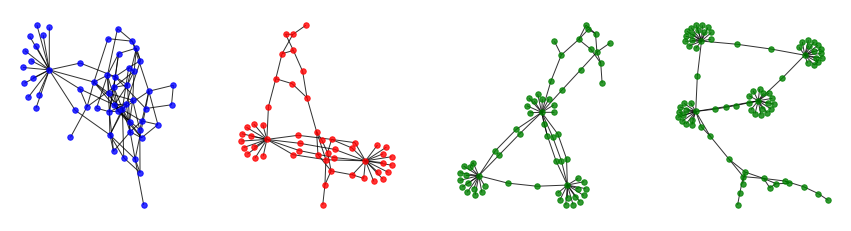

In [74]:

fig, ax = plt.subplots(1,4,figsize=(15,4))
nx.draw(g1,ax=ax[0],pos=nx.spring_layout(g1,seed=11),node_color="Blue",alpha=0.8,node_size=30)
nx.draw(g2,ax=ax[1],pos=nx.spring_layout(g2,seed=15),node_color="Red",alpha=0.8,node_size=30)
nx.draw(g3,ax=ax[2],pos=nx.spring_layout(g3,seed=18),node_color="Green",alpha=0.8,node_size=30)
nx.draw(g4,ax=ax[3],pos=nx.spring_layout(g4,seed=18),node_color="Green",alpha=0.8,node_size=30)
plt.savefig("eliminami_talk/tmp_stars.png")